In [2]:
#import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, random
import seaborn as sns 
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from keras.models import Sequential
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [4]:
batch_size = 8
epochs = 100

In [5]:
#to generate images using image augmentation techniques for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False, validation_split=0.1

)

#to generate images for validation
validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255, validation_split=0.1
)

#to generate images for testing
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

#training data 
train_generator = train_datagen.flow_from_directory(
    directory='/kaggle/input/dataset1/dataset1/training',
    target_size = (224,224),
    class_mode="categorical", batch_size=batch_size, shuffle=True, subset='training' #training split from training data

)

#validation data
validation_generator = validation_datagen.flow_from_directory(
    directory='/kaggle/input/dataset1/dataset1/training', 
    target_size = (224,224),
    class_mode="categorical", batch_size=batch_size, shuffle=True, subset='validation' #validation split from training data
)

#test data
test_generator = test_datagen.flow_from_directory(
    directory='/kaggle/input/dataset1/dataset1/testing',
    target_size = (224,224),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)


Found 10002 images belonging to 4 classes.
Found 1109 images belonging to 4 classes.
Found 2111 images belonging to 4 classes.


In [6]:
#generating the labels for the dataset
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

# ****Creating the model****

In [7]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import models

# Load MobileNet pre-trained on ImageNet, excluding the top classification layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))


# Access the output of the pre-trained layers (feature maps)
model3 = models.Sequential()
model3.add(base_model)
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.2))  # Optional dropout for regularization
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(4, activation='softmax'))
base_model.trainable = False


# Print model summary
model3.summary()


17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               25690624  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 29,051,844
Trainable params: 25,822,980
Non

In [8]:
model3.compile(
    optimizer="nadam", #Nesterov-accelerated Adaptive Moment Estimation, extension of adam
    loss="categorical_crossentropy",
    metrics=['accuracy'] #define the error metrics
)

In [9]:
data_size = len(train_generator) 
print(f"data_size: {data_size}")

#define steps taken per epoch and validation steps per epoch
steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

validation_steps = int(len(validation_generator) // batch_size)
print(f"validation size: {len(validation_generator)}")
print(f"validation_steps: {validation_steps}")

data_size: 1251
steps_per_epoch: 156
validation size: 139
validation_steps: 17


In [10]:
#fit the model on train data
model_history = model3.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
156/156 [==============================] - 35s 164ms/step - loss: 2.6975 - accuracy: 0.6659 - val_loss: 0.7298 - val_accuracy: 0.7868
Epoch 2/100
156/156 [==============================] - 23s 150ms/step - loss: 0.8811 - accuracy: 0.7540 - val_loss: 0.7824 - val_accuracy: 0.7647
Epoch 3/100
156/156 [==============================] - 23s 146ms/step - loss: 0.6943 - accuracy: 0.7738 - val_loss: 0.5857 - val_accuracy: 0.7721
Epoch 4/100
156/156 [==============================] - 23s 151ms/step - loss: 0.6374 - accuracy: 0.8125 - val_loss: 0.5427 - val_accuracy: 0.8382
Epoch 5/100
156/156 [==============================] - 24s 153ms/step - loss: 0.7728 - accuracy: 0.8045 - val_loss: 0.7388 - val_accuracy: 0.7868
Epoch 6/100
156/156 [==============================] - 22s 142ms/step - loss: 0.6546 - accuracy: 0.7981 - val_loss: 0.3286 - val_accuracy: 0.8824
Epoch 7/100
156/156 [==============================] - 22s 138ms/step - loss: 0.4911 - accuracy: 0.8510 - val_loss: 0.3321 -

In [11]:
#evaluate model performance on the test data
model_loss, model_acc= model3.evaluate(test_generator)
print("Model3 has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))

264/264 [==============================] - 15s 57ms/step - loss: 0.0535 - accuracy: 0.9896
Model3 has a loss of 0.05 and accuracy 98.96%


In [12]:
#predictions
predictions3 = model3.predict(test_generator)
print("predictions shape:", predictions3.shape)

predictions shape: (2111, 4)


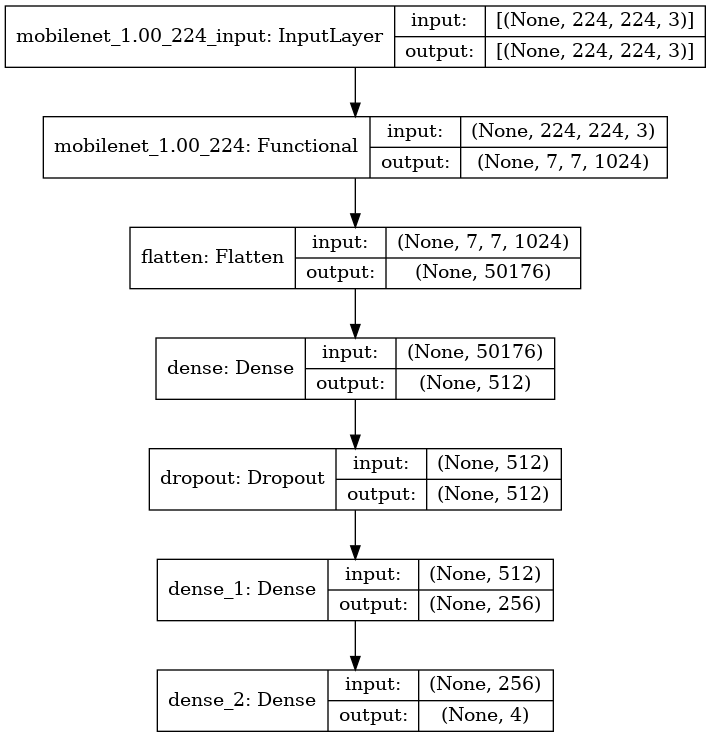

In [14]:
import tensorflow as tf
tf.keras.utils.plot_model(model3,show_shapes=True)

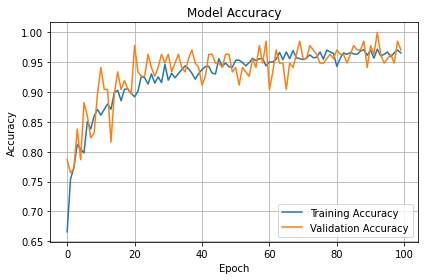

In [15]:
import matplotlib.pyplot as plt
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')  # Use default location for better placement
plt.grid(True)  # Add grid lines for better readability
plt.tight_layout()  # Adjust spacing to prevent overlapping elements
plt.show()


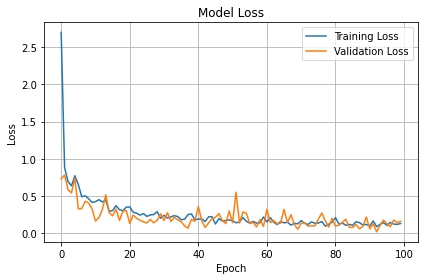

In [16]:
import matplotlib.pyplot as plt
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')  # Use default location for better placement
plt.grid(True)  # Add grid lines for better readability
plt.tight_layout()  # Adjust spacing to prevent overlapping elements
plt.show()


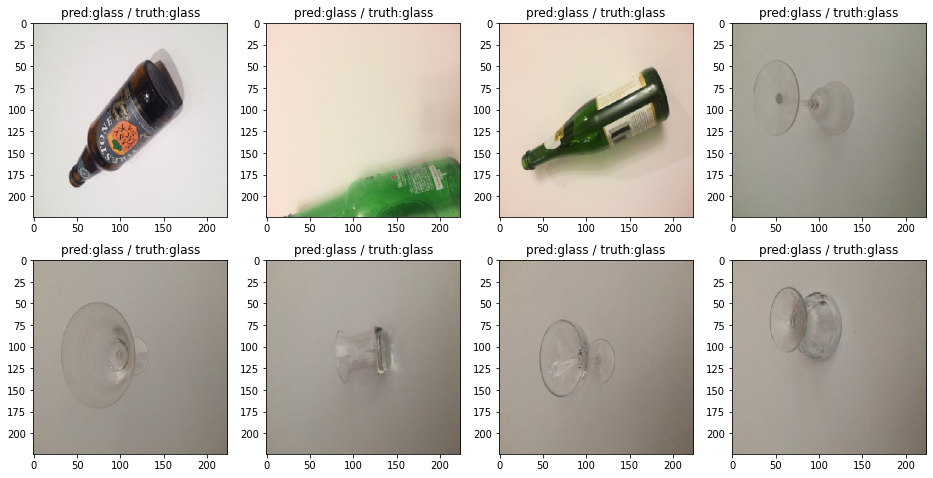

In [17]:
#generate the test set
test_x, test_y = test_generator.__getitem__(1)

#plot small parts of the results
plt.figure(figsize=(16, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(predictions3[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

IndexError: index 8 is out of bounds for axis 0 with size 8

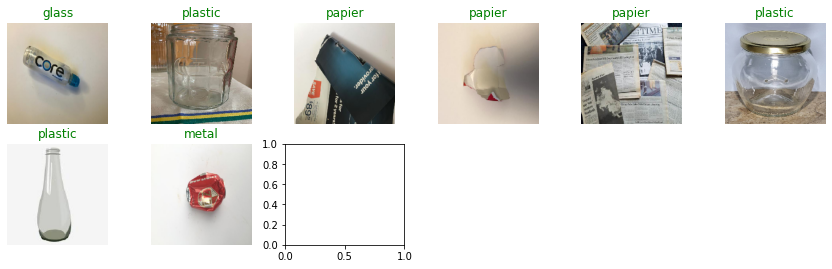

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assume labels are in the order: ['plastique', 'metal', 'papier', 'glass']
labels = ['plastic', 'metal', 'papier', 'glass']

# Generate a batch of validation images and labels
img, true_labels = next(validation_generator)
plt.figure(figsize=(15, 13))

# Predict the classes for the images
result = model3.predict(img)

# Display 30 images along with their predicted and true labels
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])

    # Get the predicted and true class indices
    pred_class = np.argmax(result[i])
    true_class = np.argmax(true_labels[i])

    # Determine the title color based on the correctness of the prediction
    if pred_class == true_class:
        title_color = 'green'
    else:
        title_color = 'red'

    # Set the title with the predicted class name and color
    plt.title(labels[pred_class], color=title_color)
    plt.axis("off")

plt.tight_layout()
plt.show()


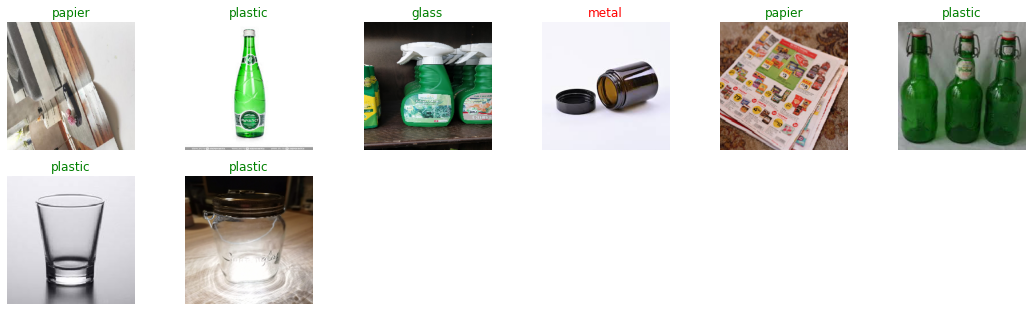

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define the class labels
labels = ['plastic', 'metal', 'papier', 'glass']

# Generate a batch of validation images and true labels
img, true_labels = next(validation_generator)

# Set the figure size
plt.figure(figsize=(15, 13))

# Predict the classes for the batch of images
result = model3.predict(img)

# Get the number of images in the batch
num_images = len(img)

# Display images with their predicted and true labels
for i in range(num_images):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])

    # Get the predicted class index and the true class index
    pred_class = np.argmax(result[i])
    true_class = np.argmax(true_labels[i])

    # Determine the title color based on the correctness of the prediction
    if pred_class == true_class:
        title_color = 'green'
    else:
        title_color = 'red'

    # Set the title with the predicted class name and color
    plt.title(labels[pred_class], color=title_color)
    plt.axis("off")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


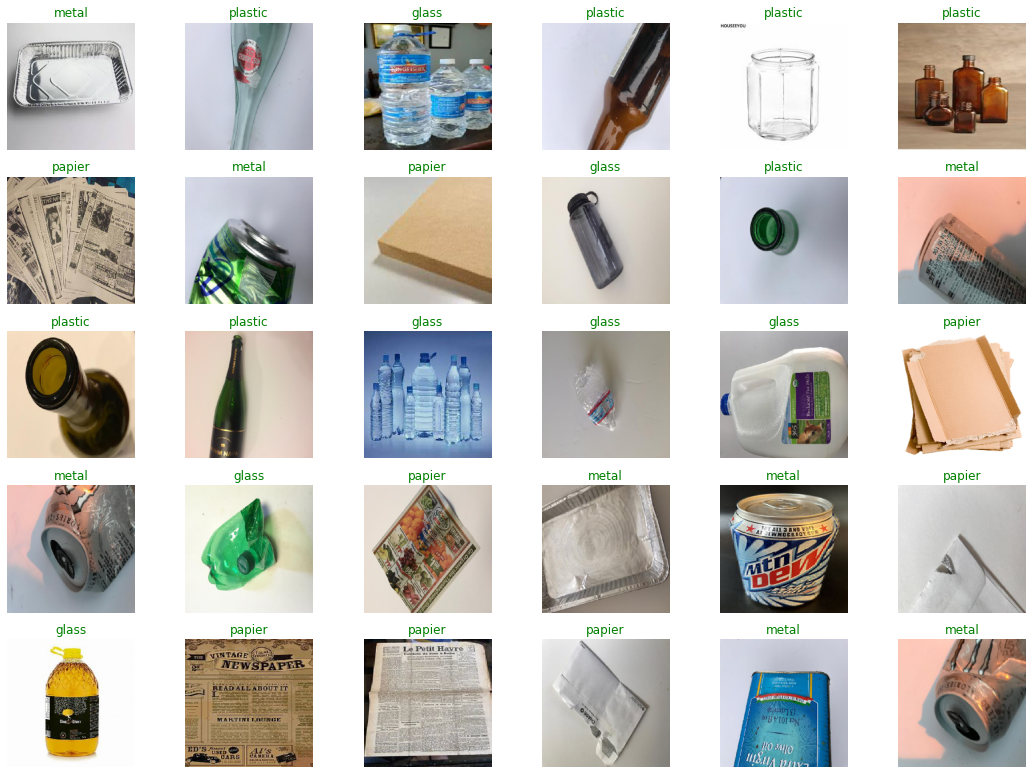

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Define the class labels
labels = ['plastic', 'metal', 'papier', 'glass']

# Number of images to display
num_images_to_display = 30

# Initialize lists to store images and labels
all_images = []
all_true_labels = []

# Generate and concatenate batches of validation images and true labels
for _ in range((num_images_to_display // batch_size) + 1):
    img_batch, true_labels_batch = next(validation_generator)
    all_images.append(img_batch)
    all_true_labels.append(true_labels_batch)

# Concatenate batches
img = np.concatenate(all_images)[:num_images_to_display]
true_labels = np.concatenate(all_true_labels)[:num_images_to_display]

# Set the figure size
plt.figure(figsize=(15, 13))

# Predict the classes for the batch of images
result = model3.predict(img)

# Display images with their predicted and true labels
for i in range(num_images_to_display):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])

    # Get the predicted class index and the true class index
    pred_class = np.argmax(result[i])
    true_class = np.argmax(true_labels[i])

    # Determine the title color based on the correctness of the prediction
    if pred_class == true_class:
        title_color = 'green'
    else:
        title_color = 'red'

    # Set the title with the predicted class name and color
    plt.title(labels[pred_class], color=title_color)
    plt.axis("off")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


In [19]:
#define function that prints classification report
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    """Evaluation function
    Prints Classification reports and confusion matrix
    """
    cm = confusion_matrix(y, y_hat)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

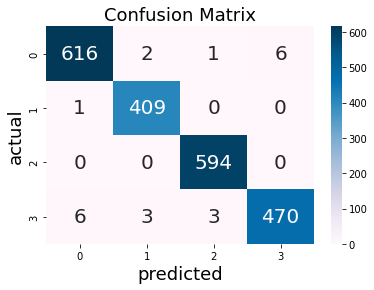

In [20]:
#print evaluation results
y_true = test_generator.labels
y_pred = model3.predict(test_generator).argmax(axis=1)

evaluation(y_true, y_pred)

In [ ]:
import tensorflow as tf
from keras.models import load_model
model3.save('model3.h5')
model_3 =tf.keras.models.load_model("/kaggle/working//model3.h5");

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model3)

In [ ]:
tflite_model = converter.convert()

In [ ]:
tflite_model

In [ ]:
with open('model.tflite', 'wb') as model_:
  model_.write(tflite_model)